# TotalText Detection and Recognition Evaluation

This notebook evaluates model outputs against ground truth for the TotalText dataset.

**Metrics computed:**
- Character-level F1 score
- Word-level F1 score
- IoU (Intersection over Union)
- Number of matched words
- List of matched words


In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from shapely.geometry import Polygon
from typing import List, Dict, Tuple
import editdistance as ed
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Helper Functions


In [2]:
def compute_polygon_iou(poly1_coords, poly2_coords):
    """
    Compute IoU between two polygons
    """
    try:
        # Convert coordinate lists to shapely Polygons
        if isinstance(poly1_coords[0], list):
            poly1 = Polygon(poly1_coords)
        else:
            # Reshape flat list to pairs
            poly1 = Polygon([(poly1_coords[i], poly1_coords[i+1]) 
                           for i in range(0, len(poly1_coords), 2)])
            
        if isinstance(poly2_coords[0], list):
            poly2 = Polygon(poly2_coords)
        else:
            poly2 = Polygon([(poly2_coords[i], poly2_coords[i+1]) 
                           for i in range(0, len(poly2_coords), 2)])
        
        if not poly1.is_valid:
            poly1 = poly1.buffer(0)
        if not poly2.is_valid:
            poly2 = poly2.buffer(0)
            
        intersection = poly1.intersection(poly2).area
        union = poly1.union(poly2).area
        
        if union == 0:
            return 0.0
        
        return intersection / union
    except Exception as e:
        print(f"Error computing IoU: {e}")
        return 0.0


In [3]:
def normalize_text(text, case_sensitive=False):
    """
    Normalize text for comparison (based on TotalText official evaluation)
    """
    
    # Remove special characters (replace with spaces)
    special_characters = "'!?.:,*\"()·[]/-"
    for char in special_characters:
        text = text.replace(char, ' ')
    
    text = text.strip()
    
    if not case_sensitive:
        text = text.upper()
    
    return text

def include_in_dictionary(transcription):
    """
    Check if transcription should be included in evaluation (from official code)
    """
    # Handle special case 's at final
    if len(transcription) >= 2 and (transcription[-2:] == "'s" or transcription[-2:] == "'S"):
        transcription = transcription[:-2]
    
    # Remove hyphens at init or final
    transcription = transcription.strip('-')
    
    # Replace special characters with spaces
    special_characters = "'!?.:,*\"()·[]/"
    for char in special_characters:
        transcription = transcription.replace(char, ' ')
    
    transcription = transcription.strip()
    
    # Check for spaces within the word
    if len(transcription) != len(transcription.replace(" ", "")):
        return False
    
    # Minimum length requirement
    # if len(transcription) < 3:
    #     return False
    
    # Check for not allowed characters
    not_allowed = "×÷·"
    if any(char in not_allowed for char in transcription):
        return False
    
    return True


In [4]:
def match_detections_to_gt(detections, ground_truths, iou_threshold=0.5):
    """
    Match detections to ground truth based on IoU
    Returns: List of tuples (det_idx, gt_idx, iou_score)
    """
    matches = []
    
    # Compute IoU matrix
    iou_matrix = np.zeros((len(detections), len(ground_truths)))
    for i, det in enumerate(detections):
        for j, gt in enumerate(ground_truths):
            if 'bbox' in det and 'bbox' in gt:
                iou = compute_polygon_iou(det['bbox'], gt['bbox'])
                iou_matrix[i, j] = iou
    
    # Greedy matching: match highest IoU first
    while True:
        if iou_matrix.size == 0:
            break
            
        max_iou = np.max(iou_matrix)
        if max_iou < iou_threshold:
            break
        
        det_idx, gt_idx = np.unravel_index(np.argmax(iou_matrix), iou_matrix.shape)
        
        matches.append((int(det_idx), int(gt_idx), float(max_iou)))
        
        # Remove matched detection and ground truth from consideration
        iou_matrix[det_idx, :] = 0
        iou_matrix[:, gt_idx] = 0
    
    return matches


In [5]:
def compute_char_level_metrics(pred_text, gt_text, case_sensitive=False):
    """
    Compute character-level precision, recall, and F1 score
    """
    pred_text = normalize_text(pred_text, case_sensitive)
    gt_text = normalize_text(gt_text, case_sensitive)
    
    if len(gt_text) == 0 and len(pred_text) == 0:
        return {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'edit_distance': 0}
    
    if len(gt_text) == 0:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'edit_distance': len(pred_text)}
    
    if len(pred_text) == 0:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'edit_distance': len(gt_text)}
    
    # Use edit distance to compute matching characters
    edit_dist = ed.eval(pred_text, gt_text)
    
    # Number of matching characters (approximate)
    max_len = max(len(pred_text), len(gt_text))
    matching_chars = max_len - edit_dist
    
    # Character-level precision and recall
    precision = matching_chars / len(pred_text) if len(pred_text) > 0 else 0
    recall = matching_chars / len(gt_text) if len(gt_text) > 0 else 0
    
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'edit_distance': edit_dist
    }


In [6]:
def compute_word_level_metrics(pred_text, gt_text, case_sensitive=False, threshold=0.5):
    """
    Compute word-level matching (exact match or normalized edit distance)
    """
    pred_text = normalize_text(pred_text, case_sensitive)
    gt_text = normalize_text(gt_text, case_sensitive)
    
    # Exact match
    if pred_text == gt_text:
        return {
            'exact_match': True,
            'normalized_edit_distance': 0.0,
            'is_match': True
        }
    
    # Normalized edit distance match
    if len(gt_text) == 0 and len(pred_text) == 0:
        return {
            'exact_match': True,
            'normalized_edit_distance': 0.0,
            'is_match': True
        }
    
    max_len = max(len(pred_text), len(gt_text))
    if max_len == 0:
        norm_ed = 0.0
    else:
        edit_dist = ed.eval(pred_text, gt_text)
        norm_ed = edit_dist / max_len
    
    is_match = norm_ed <= threshold
    
    return {
        'exact_match': False,
        'normalized_edit_distance': norm_ed,
        'is_match': is_match
    }


In [7]:
def evaluate_image(detections, ground_truths, iou_threshold=0.5, case_sensitive=False):
    """
    Evaluate detections against ground truth for a single image
    """
    # Match detections to ground truth
    matches = match_detections_to_gt(detections, ground_truths, iou_threshold)
    
    # Initialize metrics
    total_char_precision = 0
    total_char_recall = 0
    total_char_f1 = 0
    
    word_matches = 0
    exact_word_matches = 0
    matched_words = []
    matched_word_pairs = []
    ious = []
    
    num_matches = len(matches)
    
    # Compute metrics for matched pairs
    for det_idx, gt_idx, iou in matches:
        det = detections[det_idx]
        gt = ground_truths[gt_idx]
        
        det_text = det.get('text', '')
        gt_text = gt.get('text', '')
        is_dont_care = gt.get('dont_care', False)
        
        # Always compute detection metrics (IoU)
        ious.append(iou)
        
        # Skip recognition metrics for don't care regions (###)
        if is_dont_care:
            continue
        
        # Character-level metrics
        char_metrics = compute_char_level_metrics(det_text, gt_text, case_sensitive)
        total_char_precision += char_metrics['precision']
        total_char_recall += char_metrics['recall']
        total_char_f1 += char_metrics['f1']
        
        # Word-level metrics
        word_metrics = compute_word_level_metrics(det_text, gt_text, case_sensitive)
        if word_metrics['is_match']:
            word_matches += 1
            matched_words.append(normalize_text(gt_text, case_sensitive))
            matched_word_pairs.append({
                'pred': det_text,
                'gt': gt_text,
                'normalized_pred': normalize_text(det_text, case_sensitive),
                'normalized_gt': normalize_text(gt_text, case_sensitive),
                'iou': iou,
                'char_f1': char_metrics['f1']
            })
        
        if word_metrics['exact_match']:
            exact_word_matches += 1
    
    # Compute average metrics
    # Count non-dont_care matches for recognition metrics
    num_care_matches = sum(1 for _, gt_idx, _ in matches 
                          if not ground_truths[gt_idx].get('dont_care', False))
    
    if num_care_matches > 0:
        avg_char_precision = total_char_precision / num_care_matches
        avg_char_recall = total_char_recall / num_care_matches
        avg_char_f1 = total_char_f1 / num_care_matches
    else:
        avg_char_precision = 0
        avg_char_recall = 0
        avg_char_f1 = 0
    
    # IoU uses all matches (including don't care)
    if num_matches > 0:
        avg_iou = np.mean(ious)
    else:
        avg_iou = 0
    
    # Word-level precision, recall, F1
    num_detections = len(detections)
    num_gt = len(ground_truths)
    # Count only non-dont_care GT for recognition metrics
    num_care_gt = sum(1 for gt in ground_truths if not gt.get('dont_care', False))
    
    word_precision = word_matches / num_detections if num_detections > 0 else 0
    word_recall = word_matches / num_care_gt if num_care_gt > 0 else 0
    word_f1 = 2 * word_precision * word_recall / (word_precision + word_recall) \
              if (word_precision + word_recall) > 0 else 0
    
    return {
        # Character-level metrics (averaged over matched pairs)
        'char_precision': avg_char_precision,
        'char_recall': avg_char_recall,
        'char_f1': avg_char_f1,
        
        # Word-level metrics (based on all detections and ground truths)
        'word_precision': word_precision,
        'word_recall': word_recall,
        'word_f1': word_f1,
        
        # Detection metrics
        'avg_iou': avg_iou,
        'num_matched': num_matches,
        'num_detections': num_detections,
        'num_gt': num_gt,
        
        # Word matching details
        'matched_word_count': word_matches,
        'exact_word_matches': exact_word_matches,
        'matched_words': matched_words,
        'matched_word_pairs': matched_word_pairs,
        'all_ious': ious
    }


## Load Data and Configuration


In [8]:
# Configuration - Update these paths
# Model output can be a single JSON file or a directory containing multiple JSON files
MODEL_OUTPUT_PATH = '../../data/human/lowviz/converted'  # Directory with Sub*.json files
GROUND_TRUTH_PATH = '../../data/totaltext/anno.json'
IOU_THRESHOLD = 0.1
ED_DIST_THRESHOLD = 0.9
CASE_SENSITIVE = False


In [9]:
# Load model output (support directory or single file)
import ast

model_output_path = Path(MODEL_OUTPUT_PATH)
model_output = []
subject_names = []  # Track subject names

if model_output_path.is_dir():
    # Load all JSON files from directory
    print(f"Loading JSON files from directory: {model_output_path}")
    for json_file in sorted(model_output_path.glob('*.json')):
        subject_name = json_file.stem  # e.g., 'Sub161'
        subject_names.append(subject_name)
        print(f"  Loading {json_file.name} (Subject: {subject_name})...")
        with open(json_file, 'r') as f:
            data = json.load(f)
            if isinstance(data, list):
                # Track subject for each record
                for record in data:
                    record['_subject'] = subject_name
                model_output.extend(data)
            else:
                data['_subject'] = subject_name
                model_output.append(data)
else:
    # Load single JSON file
    subject_name = model_output_path.stem
    subject_names = [subject_name]
    print(f"Loading single JSON file: {model_output_path} (Subject: {subject_name})")
    with open(model_output_path, 'r') as f:
        data = json.load(f)
        if isinstance(data, list):
            for record in data:
                record['_subject'] = subject_name
            model_output = data
        else:
            data['_subject'] = subject_name
            model_output = [data]

print(f"Loaded {len(model_output)} model output records from {len(subject_names)} subjects")
print(f"Subjects: {', '.join(subject_names)}")

# Load ground truth
with open(GROUND_TRUTH_PATH, 'r') as f:
    ground_truth = json.load(f)

gt_annotations = ground_truth.get('annotations', [])
gt_images = ground_truth.get('images', [])

print(f"Loaded {len(gt_annotations)} ground truth annotations")
print(f"Loaded {len(gt_images)} image info entries")


Loading JSON files from directory: ../../data/human/lowviz/converted
  Loading Sub161.json (Subject: Sub161)...
  Loading Sub306.json (Subject: Sub306)...
  Loading Sub320.json (Subject: Sub320)...
  Loading Sub322.json (Subject: Sub322)...
  Loading Sub335.json (Subject: Sub335)...
  Loading Sub336.json (Subject: Sub336)...
  Loading Sub337.json (Subject: Sub337)...
  Loading Sub338.json (Subject: Sub338)...
  Loading Sub339.json (Subject: Sub339)...
  Loading Sub340.json (Subject: Sub340)...
  Loading Sub341.json (Subject: Sub341)...
  Loading Sub342.json (Subject: Sub342)...
  Loading Sub343.json (Subject: Sub343)...
  Loading Sub344.json (Subject: Sub344)...
Loaded 259 model output records from 14 subjects
Subjects: Sub161, Sub306, Sub320, Sub322, Sub335, Sub336, Sub337, Sub338, Sub339, Sub340, Sub341, Sub342, Sub343, Sub344
Loaded 320 ground truth annotations
Loaded 320 image info entries


## Organize Data by Image


In [10]:
# Organize ground truth by image_id
# GT structure: caption is space-separated words, bbox is list of polygons
gt_by_image = defaultdict(list)
image_info = {}

for img in gt_images:
    image_info[img['id']] = img

for ann in gt_annotations:
    caption = ann.get('caption', ann.get('text', ''))
    # Split caption by spaces to get individual words
    words = caption.split()
    
    bbox_list = ann.get('bbox', ann.get('polygon', []))
    
    # Each polygon corresponds to a word
    for i, word in enumerate(words):
        if i < len(bbox_list):
            # Extract polygon points from nested structure
            polygon = bbox_list[i]
            if polygon and isinstance(polygon, list) and len(polygon) > 0 and isinstance(polygon[0], list):
                polygon = polygon  # polygon is already [[x,y], ...]
            
            # Mark don't care regions (###)
            is_dont_care = (word == "###")
            
            gt_by_image[ann['image_id']].append({
                'bbox': polygon,
                'text': word,
                'dont_care': is_dont_care
            })

print(f"Organized ground truth for {len(gt_by_image)} images")


Organized ground truth for 320 images


In [11]:
# Organize model output by (subject, image_id) and track subject
det_by_image = defaultdict(list)
image_to_subject = {}  # Map (subject, image_id) to subject

for det in model_output:
    image_id = det.get('image_id')
    subject = det.get('_subject', 'unknown')
    # Create unique key combining subject and image_id
    unique_key = (subject, image_id)
    image_to_subject[unique_key] = subject
    
    # Parse rec_texts if it's a string representation of a list
    rec_texts = det.get('rec_texts', det.get('text', det.get('rec_text', '')))
    if isinstance(rec_texts, str) and rec_texts.startswith('['):
        try:
            rec_texts = ast.literal_eval(rec_texts)
        except:
            rec_texts = [rec_texts]
    elif not isinstance(rec_texts, list):
        rec_texts = [rec_texts] if rec_texts else []
    
    # Parse polys structure
    polys = det.get('polys', det.get('bbox', det.get('polygon', [])))
    
    # Handle nested polys structure: polys -> list of polygons -> list of points
    if polys and isinstance(polys, list):
        # polys is a list of polygons, each polygon is a list of points
        for i, poly in enumerate(polys):
            if isinstance(poly, list) and len(poly) > 0:
                # poly should be a list of points: [[x1,y1], [x2,y2], ...]
                polygon_points = poly
                
                # Check if we have coordinates with score: [[x, y, score], ...]
                if polygon_points and isinstance(polygon_points[0], list) and len(polygon_points[0]) > 2:
                    polygon_points = [[p[0], p[1]] for p in polygon_points]
                
                # Skip invalid polygons (need at least 3 points)
                if len(polygon_points) < 3:
                    continue
                
                text = rec_texts[i] if i < len(rec_texts) else ''
                det_by_image[unique_key].append({
                    'bbox': polygon_points,
                    'text': text
                })

print(f"Organized detections for {len(det_by_image)} images")
print(f"Sample detection count per image: {[len(det_by_image[img_id]) for img_id in list(det_by_image.keys())[:5]]}")
print(f"Images per subject: {dict(pd.Series(list(image_to_subject.values())).value_counts())}")


Organized detections for 255 images
Sample detection count per image: [2, 1, 1, 2, 7]
Images per subject: {'Sub161': np.int64(20), 'Sub306': np.int64(20), 'Sub320': np.int64(20), 'Sub322': np.int64(20), 'Sub339': np.int64(20), 'Sub338': np.int64(20), 'Sub343': np.int64(20), 'Sub341': np.int64(20), 'Sub340': np.int64(19), 'Sub342': np.int64(18), 'Sub344': np.int64(16), 'Sub336': np.int64(16), 'Sub335': np.int64(15), 'Sub337': np.int64(15)}


## Evaluate Each Image


In [12]:
# Evaluate each unique (subject, image_id) combination
results_per_image = {}

# Process all detection keys (subject, image_id)
for unique_key in tqdm(det_by_image.keys(), desc="Evaluating images"):
    subject, image_id = unique_key
    detections = det_by_image.get(unique_key, [])
    ground_truths = gt_by_image.get(image_id, [])
    
    image_metrics = evaluate_image(
        detections, 
        ground_truths, 
        iou_threshold=IOU_THRESHOLD,
        case_sensitive=CASE_SENSITIVE
    )
    
    # Add image info and subject
    if image_id in image_info:
        image_metrics['image_name'] = image_info[image_id].get('file_name', '')
    else:
        image_metrics['image_name'] = f"image_{image_id}"
    
    image_metrics['subject'] = subject
    image_metrics['image_id'] = image_id
    # Use unique_key as the dict key to avoid overwriting
    results_per_image[unique_key] = image_metrics

# Also process GT images that don't have detections
for gt_image_id in gt_by_image.keys():
    # Check if this GT image was already processed
    if not any(key[1] == gt_image_id for key in det_by_image.keys()):
        unique_key = ('unknown', gt_image_id)
        detections = []
        ground_truths = gt_by_image.get(gt_image_id, [])
        
        image_metrics = evaluate_image(
            detections, 
            ground_truths, 
            iou_threshold=IOU_THRESHOLD,
            case_sensitive=CASE_SENSITIVE,
            # ed_dist_thrshold=ED_DIST_THRESHOLD
        )
        
        # Add image info and subject
        if gt_image_id in image_info:
            image_metrics['image_name'] = image_info[gt_image_id].get('file_name', '')
        else:
            image_metrics['image_name'] = f"image_{gt_image_id}"
        
        image_metrics['subject'] = 'unknown'
        image_metrics['image_id'] = gt_image_id
        results_per_image[unique_key] = image_metrics

print(f"Evaluation complete for {len(results_per_image)} images")


Evaluating images: 100%|██████████| 255/255 [00:01<00:00, 242.49it/s]

Evaluation complete for 555 images


## Compute Aggregate Metrics


In [13]:
# Aggregate metrics
total_char_f1 = 0
total_word_f1 = 0
total_iou = 0
total_matched_words = 0
total_detections = 0
total_gt = 0
total_matches = 0
num_images = len(results_per_image)

for image_id, metrics in results_per_image.items():
    total_char_f1 += metrics['char_f1']
    total_word_f1 += metrics['word_f1']
    total_iou += metrics['avg_iou']
    total_matched_words += metrics['matched_word_count']
    total_detections += metrics['num_detections']
    total_gt += metrics['num_gt']
    total_matches += metrics['num_matched']

# Overall word-level metrics based on totals
overall_word_precision = total_matched_words / total_detections if total_detections > 0 else 0
overall_word_recall = total_matched_words / total_gt if total_gt > 0 else 0
overall_word_f1 = 2 * overall_word_precision * overall_word_recall / \
                 (overall_word_precision + overall_word_recall) \
                 if (overall_word_precision + overall_word_recall) > 0 else 0

aggregate_metrics = {
    'avg_char_f1': total_char_f1 / num_images if num_images > 0 else 0,
    'avg_word_f1': total_word_f1 / num_images if num_images > 0 else 0,
    'avg_iou': total_iou / num_images if num_images > 0 else 0,
    'overall_word_precision': overall_word_precision,
    'overall_word_recall': overall_word_recall,
    'overall_word_f1': overall_word_f1,
    'total_images': num_images,
    'total_matched_words': total_matched_words,
    'total_detections': total_detections,
    'total_ground_truths': total_gt,
    'total_matches': total_matches
}

# Print results
print("="*80)
print("AGGREGATE METRICS")
print("="*80)
print(f"Total Images: {aggregate_metrics['total_images']}")
print(f"Total Ground Truths: {aggregate_metrics['total_ground_truths']}")
print(f"Total Detections: {aggregate_metrics['total_detections']}")
print(f"Total Matches: {aggregate_metrics['total_matches']}")
print(f"Total Matched Words: {aggregate_metrics['total_matched_words']}")
print()
print(f"Average Character-level F1: {aggregate_metrics['avg_char_f1']:.4f}")
print(f"Average Word-level F1 (per image): {aggregate_metrics['avg_word_f1']:.4f}")
print(f"Overall Word-level F1: {aggregate_metrics['overall_word_f1']:.4f}")
print(f"Overall Word-level Precision: {aggregate_metrics['overall_word_precision']:.4f}")
print(f"Overall Word-level Recall: {aggregate_metrics['overall_word_recall']:.4f}")
print(f"Average IoU: {aggregate_metrics['avg_iou']:.4f}")
print("="*80)


AGGREGATE METRICS
Total Images: 555
Total Ground Truths: 4074
Total Detections: 779
Total Matches: 351
Total Matched Words: 74

Average Character-level F1: 0.0945
Average Word-level F1 (per image): 0.0282
Overall Word-level F1: 0.0305
Overall Word-level Precision: 0.0950
Overall Word-level Recall: 0.0182
Average IoU: 0.0789


## Compute Per-Subject Metrics


In [14]:
# Group results by subject
subject_images = defaultdict(list)
for unique_key, metrics in results_per_image.items():
    subject = metrics.get('subject', 'unknown')
    # unique_key is (subject, image_id)
    if isinstance(unique_key, tuple):
        _, image_id = unique_key
    else:
        image_id = unique_key
    subject_images[subject].append((image_id, metrics))

# Compute metrics for each subject
results_per_subject = {}

for subject, image_results in subject_images.items():
    total_char_f1 = 0
    total_word_f1 = 0
    total_iou = 0
    total_matched_words = 0
    total_detections = 0
    total_gt = 0
    total_matches = 0
    
    all_matched_word_pairs = []
    all_matched_words = []
    
    for image_id, metrics in image_results:
        total_char_f1 += metrics['char_f1']
        total_word_f1 += metrics['word_f1']
        total_iou += metrics['avg_iou']
        total_matched_words += metrics['matched_word_count']
        total_detections += metrics['num_detections']
        total_gt += metrics['num_gt']
        total_matches += metrics['num_matched']
        
        # Collect matched word pairs
        for pair in metrics.get('matched_word_pairs', []):
            pair_with_image = pair.copy()
            pair_with_image['image_id'] = image_id
            all_matched_word_pairs.append(pair_with_image)
        
        # Collect matched words
        all_matched_words.extend(metrics.get('matched_words', []))
    
    num_images = len(image_results)
    
    # Overall word-level metrics for this subject
    overall_word_precision = total_matched_words / total_detections if total_detections > 0 else 0
    overall_word_recall = total_matched_words / total_gt if total_gt > 0 else 0
    overall_word_f1 = 2 * overall_word_precision * overall_word_recall / \
                     (overall_word_precision + overall_word_recall) \
                     if (overall_word_precision + overall_word_recall) > 0 else 0
    
    results_per_subject[subject] = {
        # Average metrics
        'avg_char_f1': total_char_f1 / num_images if num_images > 0 else 0,
        'avg_word_f1': total_word_f1 / num_images if num_images > 0 else 0,
        'avg_iou': total_iou / num_images if num_images > 0 else 0,
        
        # Overall metrics
        'overall_word_precision': overall_word_precision,
        'overall_word_recall': overall_word_recall,
        'overall_word_f1': overall_word_f1,
        
        # Counts
        'num_images': num_images,
        'total_matched_words': total_matched_words,
        'total_detections': total_detections,
        'total_ground_truths': total_gt,
        'total_matches': total_matches,
        
        # Detailed results
        'matched_word_pairs': all_matched_word_pairs,
        'matched_words': all_matched_words,
        'unique_matched_words': list(set(all_matched_words)),
        
        # Image IDs in this subject
        'image_ids': [img_id for img_id, _ in image_results]
    }

print(f"Computed metrics for {len(results_per_subject)} subjects")


Computed metrics for 15 subjects


In [15]:
# Print per-subject metrics
print("="*80)
print("PER-SUBJECT METRICS")
print("="*80)

for subject in sorted(results_per_subject.keys()):
    metrics = results_per_subject[subject]
    print(f"\n--- Subject: {subject} ---")
    print(f"  Number of images: {metrics['num_images']}")
    print(f"  Total detections: {metrics['total_detections']}")
    print(f"  Total ground truths: {metrics['total_ground_truths']}")
    print(f"  Total matched words: {metrics['total_matched_words']}")
    print(f"  Unique matched words: {len(metrics['unique_matched_words'])}")
    print()
    print(f"  Avg Character F1: {metrics['avg_char_f1']:.4f}")
    print(f"  Avg Word F1: {metrics['avg_word_f1']:.4f}")
    print(f"  Overall Word F1: {metrics['overall_word_f1']:.4f}")
    print(f"  Overall Word Precision: {metrics['overall_word_precision']:.4f}")
    print(f"  Overall Word Recall: {metrics['overall_word_recall']:.4f}")
    print(f"  Avg IoU: {metrics['avg_iou']:.4f}")
    
    # Show some matched word pairs
    if metrics['matched_word_pairs']:
        print(f"\n  Sample matched word pairs (first 5):")
        for pair in metrics['matched_word_pairs'][:5]:
            print(f"    Image {pair['image_id']}: '{pair['pred']}' -> '{pair['gt']}' "
                  f"(IoU: {pair['iou']:.3f}, Char F1: {pair['char_f1']:.3f})")


PER-SUBJECT METRICS

--- Subject: Sub161 ---
  Number of images: 20
  Total detections: 64
  Total ground truths: 151
  Total matched words: 4
  Unique matched words: 4

  Avg Character F1: 0.1455
  Avg Word F1: 0.0460
  Overall Word F1: 0.0372
  Overall Word Precision: 0.0625
  Overall Word Recall: 0.0265
  Avg IoU: 0.1759

  Sample matched word pairs (first 5):
    Image 64: 'sport' -> 'SPORT' (IoU: 0.255, Char F1: 1.000)
    Image 128: '1889' -> '1889' (IoU: 0.181, Char F1: 1.000)
    Image 144: 'sun' -> 'sun' (IoU: 0.413, Char F1: 1.000)
    Image 208: 'the glass' -> 'Glass' (IoU: 0.352, Char F1: 0.714)

--- Subject: Sub306 ---
  Number of images: 20
  Total detections: 69
  Total ground truths: 151
  Total matched words: 3
  Unique matched words: 3

  Avg Character F1: 0.1907
  Avg Word F1: 0.0386
  Overall Word F1: 0.0273
  Overall Word Precision: 0.0435
  Overall Word Recall: 0.0199
  Avg IoU: 0.1706

  Sample matched word pairs (first 5):
    Image 144: 'sun' -> 'sun' (IoU: 0.4

In [16]:
# Create DataFrame for per-subject results (summary)
df_subjects = pd.DataFrame([
    {
        'subject': subject,
        'num_images': metrics['num_images'],
        'avg_char_f1': metrics['avg_char_f1'],
        'avg_word_f1': metrics['avg_word_f1'],
        'overall_word_f1': metrics['overall_word_f1'],
        'overall_word_precision': metrics['overall_word_precision'],
        'overall_word_recall': metrics['overall_word_recall'],
        'avg_iou': metrics['avg_iou'],
        'total_matched_words': metrics['total_matched_words'],
        'total_detections': metrics['total_detections'],
        'total_ground_truths': metrics['total_ground_truths'],
        'unique_matched_words': len(metrics['unique_matched_words'])
    }
    for subject, metrics in results_per_subject.items()
]).sort_values('subject')

print("\nPer-Subject Summary DataFrame:")
df_subjects



Per-Subject Summary DataFrame:


,subject,num_images,avg_char_f1,avg_word_f1,overall_word_f1,overall_word_precision,overall_word_recall,avg_iou,total_matched_words,total_detections,total_ground_truths,unique_matched_words
0,Sub161,20,0.145520,0.045952,0.037209,0.062500,0.026490,0.175876,4,64,151,4
1,Sub306,20,0.190667,0.038571,0.027273,0.043478,0.019868,0.170611,3,69,151,3
2,Sub320,20,0.226351,0.070595,0.066946,0.090909,0.052980,0.187679,8,88,151,8
3,Sub322,20,0.217107,0.046429,0.030151,0.062500,0.019868,0.158399,3,48,151,3
4,Sub335,15,0.259057,0.085529,0.100840,0.142857,0.077922,0.220923,6,42,77,6
5,Sub336,13,0.140146,0.047619,0.044944,0.133333,0.027027,0.119563,2,15,74,2
6,Sub337,14,0.020130,0.000000,0.000000,0.000000,0.000000,0.112282,0,16,106,0
7,Sub338,20,0.196551,0.000000,0.000000,0.000000,0.000000,0.134996,0,43,151,0
8,Sub339,20,0.187858,0.066944,0.060606,0.127660,0.039735,0.142091,6,47,151,6
9,Sub340,19,0.164078,0.059064,0.039024,0.064516,0.027972,0.201505,4,62,143,4


## Per-Subject Word Pairs Details


In [17]:
# Create detailed DataFrame with word pairs for each subject and image
detailed_pairs = []
for unique_key, metrics in results_per_image.items():
    subject = metrics.get('subject', 'unknown')
    image_id = metrics.get('image_id')
    image_name = metrics.get('image_name', '')
    
    # Add each word pair as a separate row
    for pair in metrics.get('matched_word_pairs', []):
        detailed_pairs.append({
            'subject': subject,
            'image_id': image_id,
            'image_name': image_name,
            'pred': pair['pred'],
            'gt': pair['gt'],
            'normalized_pred': pair['normalized_pred'],
            'normalized_gt': pair['normalized_gt'],
            'iou': pair['iou'],
            'char_f1': pair['char_f1']
        })

df_word_pairs = pd.DataFrame(detailed_pairs)
print(f"\nTotal word pairs across all subjects: {len(df_word_pairs)}")
print(f"\nWord pairs by subject:")
print(df_word_pairs.groupby('subject').size())
df_word_pairs.head(20)



Total word pairs across all subjects: 74

Word pairs by subject:
subject
Sub161     4
Sub306     3
Sub320     8
Sub322     3
Sub335     6
Sub336     2
Sub339     6
Sub340     4
Sub341    11
Sub342     6
Sub343    12
Sub344     9
dtype: int64


,subject,image_id,image_name,pred,gt,normalized_pred,normalized_gt,iou,char_f1
0,Sub161,64,16/0000095.jpg,sport,SPORT,SPORT,SPORT,0.255167,1.000000
1,Sub161,128,16/0000146.jpg,1889,1889,1889,1889,0.181089,1.000000
2,Sub161,144,16/0000166.jpg,sun,sun,SUN,SUN,0.413278,1.000000
3,Sub161,208,16/0000210.jpg,the glass,Glass,THE GLASS,GLASS,0.351997,0.714286
4,Sub306,144,16/0000166.jpg,sun,sun,SUN,SUN,0.423066,1.000000
5,Sub306,208,16/0000210.jpg,glass,Glass,GLASS,GLASS,0.109714,1.000000
6,Sub306,288,16/0000277.jpg,rice,Rice,RICE,RICE,0.363864,1.000000
7,Sub320,64,16/0000095.jpg,cafes,cafes,CAFES,CAFES,0.363067,1.000000
8,Sub320,64,16/0000095.jpg,sport,SPORT,SPORT,SPORT,0.211685,1.000000
9,Sub320,64,16/0000095.jpg,boating,BOATING,BOATING,BOATING,0.129162,1.000000


## Convert to DataFrame for Analysis


In [18]:
# Create DataFrame from per-image results
df_results = pd.DataFrame([
    {
        'image_id': metrics.get('image_id'),
        'subject': metrics.get('subject', 'unknown'),
        'image_name': metrics['image_name'],
        'char_f1': metrics['char_f1'],
        'char_precision': metrics['char_precision'],
        'char_recall': metrics['char_recall'],
        'word_f1': metrics['word_f1'],
        'word_precision': metrics['word_precision'],
        'word_recall': metrics['word_recall'],
        'avg_iou': metrics['avg_iou'],
        'num_matched': metrics['num_matched'],
        'num_detections': metrics['num_detections'],
        'num_gt': metrics['num_gt'],
        'matched_word_count': metrics['matched_word_count'],
        'exact_word_matches': metrics['exact_word_matches'],
        'matched_words': ', '.join(metrics['matched_words'][:10]),  # First 10 words
        'matched_word_pairs': str(metrics['matched_word_pairs'])  # Store as string for CSV
    }
    for unique_key, metrics in results_per_image.items()
])

print(f"Created DataFrame with {len(df_results)} rows")
print("\nColumns:", df_results.columns.tolist())
df_results.head(10)


Created DataFrame with 555 rows

Columns: ['image_id', 'subject', 'image_name', 'char_f1', 'char_precision', 'char_recall', 'word_f1', 'word_precision', 'word_recall', 'avg_iou', 'num_matched', 'num_detections', 'num_gt', 'matched_word_count', 'exact_word_matches', 'matched_words', 'matched_word_pairs']


,image_id,subject,image_name,char_f1,char_precision,char_recall,word_f1,word_precision,word_recall,avg_iou,num_matched,num_detections,num_gt,matched_word_count,exact_word_matches,matched_words,matched_word_pairs
0,0,Sub161,16/0000002.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,2,0,0,,[]
1,16,Sub161,16/0000018.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,26,0,0,,[]
2,32,Sub161,16/0000024.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,15,0,0,,[]
3,48,Sub161,16/0000061.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,8,0,0,,[]
4,64,Sub161,16/0000095.jpg,0.395604,0.398810,0.392857,0.133333,0.142857,0.125000,0.258802,4,7,8,1,1,SPORT,"[{'pred': 'sport', 'gt': 'SPORT', 'normalized_..."
5,80,Sub161,16/0000099.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,7,0,0,,[]
6,96,Sub161,16/0000114.jpg,0.058824,0.062500,0.055556,0.000000,0.000000,0.000000,0.238574,2,2,2,0,0,,[]
7,112,Sub161,16/0000117.jpg,0.190476,0.117647,0.500000,0.000000,0.000000,0.000000,0.261368,2,2,4,0,0,,[]
8,128,Sub161,16/0000146.jpg,0.350000,0.354167,0.354167,0.166667,0.166667,0.166667,0.384372,4,6,6,1,1,1889,"[{'pred': '1889', 'gt': '1889', 'normalized_pr..."
9,144,Sub161,16/0000166.jpg,0.454545,0.455556,0.455556,0.285714,0.333333,0.250000,0.315739,3,3,4,1,1,SUN,"[{'pred': 'sun', 'gt': 'sun', 'normalized_pred..."


In [19]:
# Create DataFrame from per-image results
df_results = pd.DataFrame([
    {
        'image_id': img_id,
        'image_name': metrics['image_name'],
        'char_f1': metrics['char_f1'],
        'char_precision': metrics['char_precision'],
        'char_recall': metrics['char_recall'],
        'word_f1': metrics['word_f1'],
        'word_precision': metrics['word_precision'],
        'word_recall': metrics['word_recall'],
        'avg_iou': metrics['avg_iou'],
        'num_matched': metrics['num_matched'],
        'num_detections': metrics['num_detections'],
        'num_gt': metrics['num_gt'],
        'matched_word_count': metrics['matched_word_count'],
        'exact_word_matches': metrics['exact_word_matches'],
        'matched_words': ', '.join(metrics['matched_words'][:10])  # First 10 words
    }
    for img_id, metrics in results_per_image.items()
])

print(f"Created DataFrame with {len(df_results)} rows")
df_results.head(10)


Created DataFrame with 555 rows


,image_id,image_name,char_f1,char_precision,char_recall,word_f1,word_precision,word_recall,avg_iou,num_matched,num_detections,num_gt,matched_word_count,exact_word_matches,matched_words
0,"(Sub161, 0)",16/0000002.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,2,0,0,
1,"(Sub161, 16)",16/0000018.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,26,0,0,
2,"(Sub161, 32)",16/0000024.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,15,0,0,
3,"(Sub161, 48)",16/0000061.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,8,0,0,
4,"(Sub161, 64)",16/0000095.jpg,0.395604,0.398810,0.392857,0.133333,0.142857,0.125000,0.258802,4,7,8,1,1,SPORT
5,"(Sub161, 80)",16/0000099.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,2,7,0,0,
6,"(Sub161, 96)",16/0000114.jpg,0.058824,0.062500,0.055556,0.000000,0.000000,0.000000,0.238574,2,2,2,0,0,
7,"(Sub161, 112)",16/0000117.jpg,0.190476,0.117647,0.500000,0.000000,0.000000,0.000000,0.261368,2,2,4,0,0,
8,"(Sub161, 128)",16/0000146.jpg,0.350000,0.354167,0.354167,0.166667,0.166667,0.166667,0.384372,4,6,6,1,1,1889
9,"(Sub161, 144)",16/0000166.jpg,0.454545,0.455556,0.455556,0.285714,0.333333,0.250000,0.315739,3,3,4,1,1,SUN


In [20]:
# Summary statistics
print("Per-Image Metrics Summary:")
df_results[['char_f1', 'word_f1', 'avg_iou', 'matched_word_count']].describe()


Per-Image Metrics Summary:


,char_f1,word_f1,avg_iou,matched_word_count
count,555.000000,555.000000,555.000000,555.000000
mean,0.094481,0.028152,0.078857,0.133333
std,0.213375,0.087036,0.132162,0.425142
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.165937,0.000000
max,1.000000,0.666667,0.528219,3.000000


## Save Results


In [ ]:
# # Save detailed results as JSON
# output_path = '../../results/totaltext_evaluation_results.json'
# Path(output_path).parent.mkdir(parents=True, exist_ok=True)

# with open(output_path, 'w') as f:
#     json.dump({
#         'aggregate_metrics': aggregate_metrics,
#         'per_subject_results': results_per_subject,
#         'per_image_results': {str(k): v for k, v in results_per_image.items()}
#     }, f, indent=2)

# print(f"Results saved to: {output_path}")

# # Save DataFrames as CSV
# csv_path_images = '../../results/totaltext_evaluation_per_image.csv'
# df_results.to_csv(csv_path_images, index=False)
# print(f"Per-image results saved to: {csv_path_images}")

# csv_path_subjects = '../../results/totaltext_evaluation_per_subject.csv'
# df_subjects.to_csv(csv_path_subjects, index=False)
# print(f"Per-subject results saved to: {csv_path_subjects}")

# # Save detailed word pairs
# csv_path_word_pairs = '../../results/totaltext_word_pairs_detailed.csv'
# df_word_pairs.to_csv(csv_path_word_pairs, index=False)
# print(f"Detailed word pairs saved to: {csv_path_word_pairs}")


## 查看具体Subject的Word Pairs


In [ ]:
# 查看特定subject的所有word pairs
# 例如：查看Sub161的所有匹配
if len(df_word_pairs) > 0:
    example_subject = 'Sub161'
    subject_pairs = df_word_pairs[df_word_pairs['subject'] == example_subject]
    
    print(f"\n{example_subject} - Total matched word pairs: {len(subject_pairs)}")
    print(f"\nSample (first 10):")
    print(subject_pairs[['image_name', 'pred', 'gt', 'normalized_pred', 'normalized_gt', 'iou', 'char_f1']].head(10))
    
    # 查看特定图像的word pairs
    if len(subject_pairs) > 0:
        example_image_id = subject_pairs.iloc[0]['image_id']
        image_pairs = subject_pairs[subject_pairs['image_id'] == example_image_id]
        print(f"\n\nImage {example_image_id} word pairs:")
        for idx, row in image_pairs.iterrows():
            print(f"  '{row['pred']}' -> '{row['gt']}' "
                  f"(normalized: '{row['normalized_pred']}' -> '{row['normalized_gt']}', "
                  f"IoU: {row['iou']:.3f}, Char F1: {row['char_f1']:.3f})")
else:
    print("No word pairs matched.")



Sub161 - Total matched word pairs: 0

Sample (first 10):
Empty DataFrame
Columns: [image_name, pred, gt, normalized_pred, normalized_gt, iou, char_f1]
Index: []


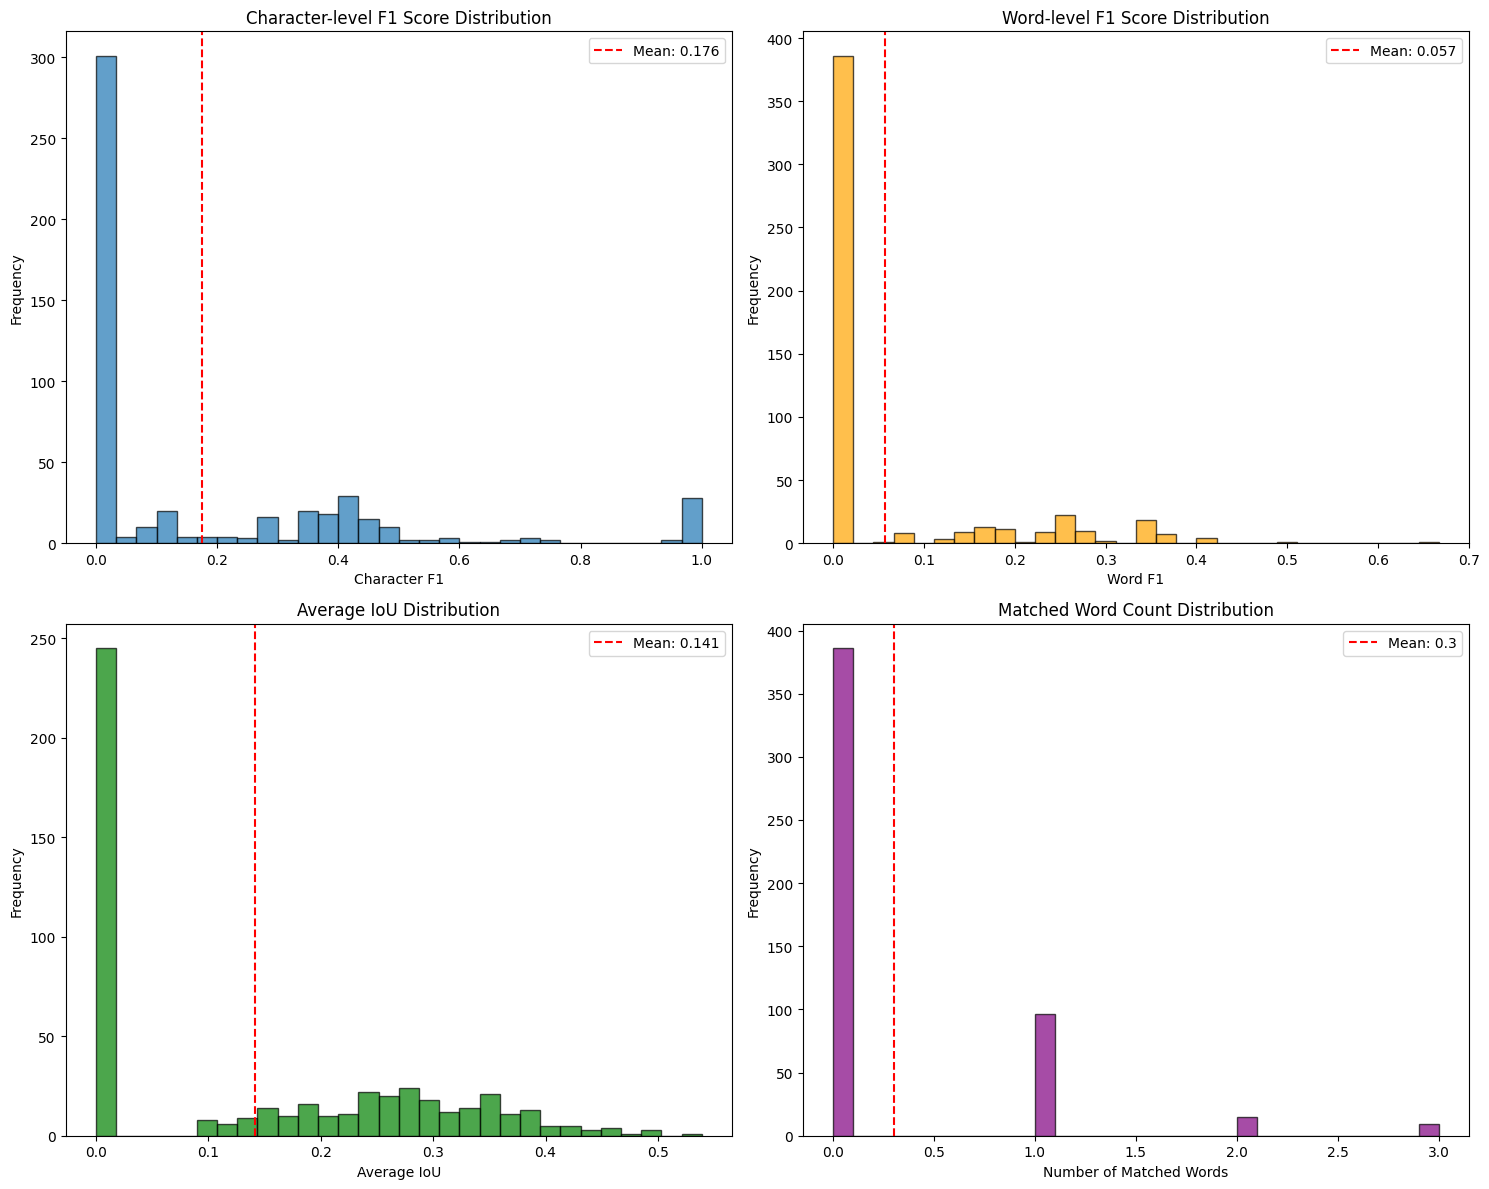

In [ ]:
# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Character F1 distribution
axes[0, 0].hist(df_results['char_f1'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Character-level F1 Score Distribution')
axes[0, 0].set_xlabel('Character F1')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(aggregate_metrics['avg_char_f1'], color='red', linestyle='--', 
                   label=f"Mean: {aggregate_metrics['avg_char_f1']:.3f}")
axes[0, 0].legend()

# Word F1 distribution
axes[0, 1].hist(df_results['word_f1'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Word-level F1 Score Distribution')
axes[0, 1].set_xlabel('Word F1')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(aggregate_metrics['avg_word_f1'], color='red', linestyle='--',
                   label=f"Mean: {aggregate_metrics['avg_word_f1']:.3f}")
axes[0, 1].legend()

# IoU distribution
axes[1, 0].hist(df_results['avg_iou'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('Average IoU Distribution')
axes[1, 0].set_xlabel('Average IoU')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(aggregate_metrics['avg_iou'], color='red', linestyle='--',
                   label=f"Mean: {aggregate_metrics['avg_iou']:.3f}")
axes[1, 0].legend()

# Matched words distribution
axes[1, 1].hist(df_results['matched_word_count'], bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Matched Word Count Distribution')
axes[1, 1].set_xlabel('Number of Matched Words')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df_results['matched_word_count'].mean(), color='red', linestyle='--',
                   label=f"Mean: {df_results['matched_word_count'].mean():.1f}")
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## Save Results


In [ ]:
# # Save detailed results as JSON
# output_path = '../../results/totaltext_evaluation_results.json'
# Path(output_path).parent.mkdir(parents=True, exist_ok=True)

# with open(output_path, 'w') as f:
#     json.dump({
#         'aggregate_metrics': aggregate_metrics,
#         'per_subject_results': results_per_subject,
#         'per_image_results': {str(k): v for k, v in results_per_image.items()}
#     }, f, indent=2)

# print(f"Results saved to: {output_path}")

# # Save DataFrames as CSV
# csv_path_images = '../../results/totaltext_evaluation_per_image.csv'
# df_results.to_csv(csv_path_images, index=False)
# print(f"Per-image results saved to: {csv_path_images}")

# csv_path_subjects = '../../results/totaltext_evaluation_per_subject.csv'
# df_subjects.to_csv(csv_path_subjects, index=False)
# print(f"Per-subject results saved to: {csv_path_subjects}")


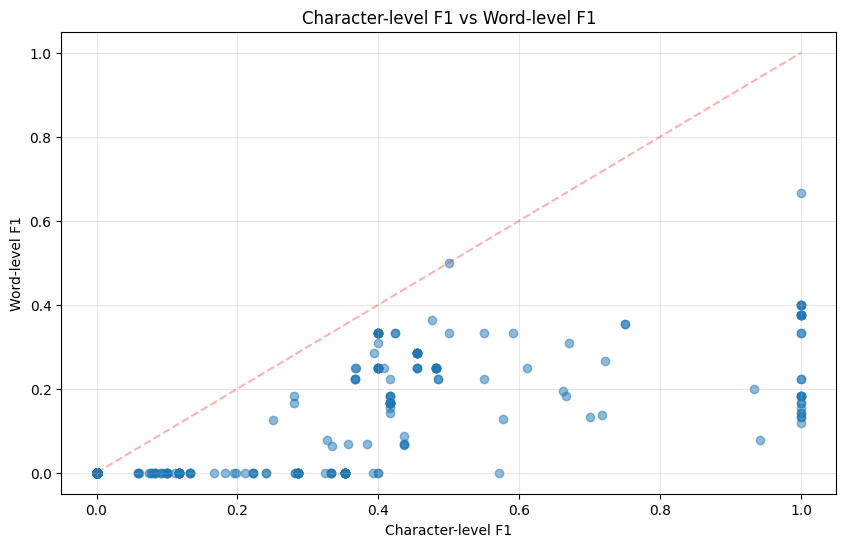

In [ ]:
# Scatter plot: Char F1 vs Word F1
plt.figure(figsize=(10, 6))
plt.scatter(df_results['char_f1'], df_results['word_f1'], alpha=0.5)
plt.xlabel('Character-level F1')
plt.ylabel('Word-level F1')
plt.title('Character-level F1 vs Word-level F1')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.3)  # diagonal line
plt.grid(True, alpha=0.3)
plt.show()


## Sample Results


In [ ]:
# Show best performing images
print("Top 10 images by Word F1:")
df_results.nlargest(10, 'word_f1')[['image_name', 'char_f1', 'word_f1', 'avg_iou', 'matched_word_count']]


Top 10 images by Word F1:


,image_name,char_f1,word_f1,avg_iou,matched_word_count
18,5/0000114.jpg,1.0,0.666667,0.151620,1
133,12/0000264.jpg,0.5,0.500000,0.293850,1
113,6/0000210.jpg,1.0,0.400000,0.344161,1
201,6/0000210.jpg,1.0,0.400000,0.380954,1
289,3/0000210.jpg,1.0,0.400000,0.340874,1
362,3/0000210.jpg,1.0,0.400000,0.373120,1
89,8/0000095.jpg,1.0,0.375000,0.224932,3
123,5/0000095.jpg,1.0,0.375000,0.233054,3
157,16/0000095.jpg,1.0,0.375000,0.235548,3
227,16/0000095.jpg,1.0,0.375000,0.235548,3


In [ ]:
# Show worst performing images
print("Bottom 10 images by Word F1:")
df_results.nsmallest(10, 'word_f1')[['image_name', 'char_f1', 'word_f1', 'avg_iou', 'matched_word_count']]


Bottom 10 images by Word F1:


,image_name,char_f1,word_f1,avg_iou,matched_word_count
0,2/0000002.jpg,0.000000,0.0,0.000000,0
1,9/0000018.jpg,0.000000,0.0,0.158008,0
2,14/0000061.jpg,0.000000,0.0,0.000000,0
3,13/0000099.jpg,0.000000,0.0,0.000000,0
4,2/0000114.jpg,0.000000,0.0,0.181950,0
7,4/0000166.jpg,0.000000,0.0,0.288245,0
8,3/0000181.jpg,0.000000,0.0,0.269958,0
9,15/0000184.jpg,0.285714,0.0,0.108265,0
10,16/0000205.jpg,0.083333,0.0,0.259048,0
11,5/0000210.jpg,0.074074,0.0,0.242918,0


In [ ]:
# Show some matched word pairs from a sample image
if len(results_per_image) > 0:
    sample_image_id = list(results_per_image.keys())[0]
    sample_metrics = results_per_image[sample_image_id]

    print(f"\nSample Image ID: {sample_image_id}")
    print(f"Image Name: {sample_metrics['image_name']}")
    print(f"\nMatched Word Pairs:")
    if sample_metrics['matched_word_pairs']:
        for pair in sample_metrics['matched_word_pairs'][:10]:
            print(f"  Pred: '{pair['pred']}' -> GT: '{pair['gt']}' (IoU: {pair['iou']:.3f}, Char F1: {pair['char_f1']:.3f})")
    else:
        print("  No matched word pairs")



Sample Image ID: ('Sub002', 5)
Image Name: 2/0000002.jpg

Matched Word Pairs:
  No matched word pairs


## Save Results


In [ ]:
# Save detailed results as JSON
# output_path = '../../results/totaltext_evaluation_results.json'
# Path(output_path).parent.mkdir(parents=True, exist_ok=True)

# with open(output_path, 'w') as f:
#     json.dump({
#         'aggregate_metrics': aggregate_metrics,
#         'per_image_results': {str(k): v for k, v in results_per_image.items()}
#     }, f, indent=2)

# print(f"Results saved to: {output_path}")

# # Save DataFrame as CSV
# csv_path = '../../results/totaltext_evaluation_per_image.csv'
# df_results.to_csv(csv_path, index=False)
# print(f"Per-image results saved to: {csv_path}")
